In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from gemelli.rpca import joint_rpca
from biom import Table
from tqdm.notebook import tqdm

#plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm # for a scatter plot
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import metadata
metadata = pd.read_csv('../../data/case-studies/decomposer/metadata_v0.csv', index_col=0)
tables = {}

# import/match metabolomics
metabolomics = pd.read_csv('../../data/case-studies/decomposer/tables/GNPS-raw-metabolomics-quant-table.csv', index_col=0)
metabolomics = metabolomics.drop(['row m/z', 'row retention time'], axis=1)
map_names = pd.read_csv('../../data/case-studies/decomposer/annotations/metabolite_sample_names.txt', sep='\t', index_col=0).orig_sample_name.to_dict()
metabolomics.columns = [c.replace(' Peak area','') for c in metabolomics.columns]
metabolomics.index = ['metab_' + str(i) for i in metabolomics.index]
metabolomics = metabolomics[set(metabolomics.columns) & set(map_names.keys())]
metabolomics.columns = [map_names[c] for c in metabolomics.columns]
tables['metabolomics'] = metabolomics.copy()

# import the rest
all_tables = {'mag':'../../data/case-studies/decomposer/tables/MAG_bact_table.tsv',
            '18S':'../../data/case-studies/decomposer/tables/18S_ASV_table.tsv',
             '16S':'../../data/case-studies/decomposer/tables/16S_ASV_table.tsv',
            'gene_module':'../../data/case-studies/decomposer/tables/MAG_bact_gene_modules_table.tsv'}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = pd.read_csv(tbl_path, sep='\t', index_col=0)
    
# match and filter the tables
def filter_table(df, use_ids):
    df = df[use_ids]
    df = df[df.sum(1) > 0]
    return df


all_shared_samples = set(metadata.index) & set.intersection(*[set(t.columns) for t in tables.values()])
tables = {tblid:filter_table(tbl, all_shared_samples) for tblid, tbl in tables.items()}
metadata = metadata.reindex(all_shared_samples)
metadata = pd.concat([df for _, df in metadata.groupby('subjects') 
                      if len(set(df.add_0c_group)) >= 4])
all_shared_samples = set(metadata.index) & set.intersection(*[set(t.columns) for t in tables.values()])
tables = {tblid:filter_table(tbl, all_shared_samples) for tblid, tbl in tables.items()}
metadata = metadata.reindex(all_shared_samples)
tables = {tblid:Table(tbl.values, tbl.index, tbl.columns) for tblid, tbl in tables.items()}
tables


{'metabolomics': 2333 x 374 <class 'biom.table.Table'> with 104825 nonzero entries (12% dense),
 'mag': 257 x 374 <class 'biom.table.Table'> with 58498 nonzero entries (60% dense),
 '18S': 5473 x 374 <class 'biom.table.Table'> with 114755 nonzero entries (5% dense),
 '16S': 14237 x 374 <class 'biom.table.Table'> with 318875 nonzero entries (5% dense),
 'gene_module': 377 x 374 <class 'biom.table.Table'> with 117093 nonzero entries (83% dense)}

In [3]:
"""
Copy what was done in the paper for each omic:

Example: https://github.com/Metcalf-Lab/2023-Universal-microbial-decomposer-network/blob/35bf61a279a48953351119d0c5e374c4a2e29d9e/pmi_modeling/metagenomics/abundance/shotgun-soil-MAG-tax-levels.py#L57C1-L74C42

"""

# designate data
y = metadata['add_0c']
y = (y.astype(float))
metadata['y'] = y

# group by body
groups = metadata['subjects']

# outer_cv creates 35 folds by leave-one-body-out for estimating generalization error
outer_cv = LeaveOneGroupOut().split(metadata['y'], groups=groups)

# prints the number of folds in the outer loop
print("Number of outer folds to perform: ", LeaveOneGroupOut().get_n_splits(metadata['y'], groups=groups))

# hyperparameter grid to test
param_grid = {"max_depth": [None, 4],
              "max_features": ['auto', 0.2],
              "bootstrap": [True, False]}

# set the train and test labels
i_ = 0
cols_split_ = []
for train_ids, test_ids in outer_cv:
    metadata['traintest_%i' % (i_)] = 'test'
    metadata.loc[metadata.index[train_ids], 'traintest_%i' % (i_)] = 'train'
    cols_split_.append('traintest_%i' % (i_))
    i_ += 1

"""
Add from prev. paper
"""
# make it so we do this task within each site seperately (since they seperate by location)
for c_ in cols_split_:
    metadata.loc[metadata.facility != metadata[metadata[c_] == 'test'].facility[0], c_] = 'test'

{c_:metadata[c_].value_counts()['train'] for c_ in cols_split_}


Number of outer folds to perform:  23


{'traintest_0': 41,
 'traintest_1': 107,
 'traintest_2': 112,
 'traintest_3': 108,
 'traintest_4': 105,
 'traintest_5': 112,
 'traintest_6': 44,
 'traintest_7': 175,
 'traintest_8': 173,
 'traintest_9': 42,
 'traintest_10': 47,
 'traintest_11': 172,
 'traintest_12': 171,
 'traintest_13': 172,
 'traintest_14': 176,
 'traintest_15': 174,
 'traintest_16': 173,
 'traintest_17': 174,
 'traintest_18': 176,
 'traintest_19': 174,
 'traintest_20': 113,
 'traintest_21': 108,
 'traintest_22': 110}

In [11]:
{mod_:(tables[mod_],
       (tables[mod_].sum('observation').min(), tables[mod_].sum('observation').max()),
      (tables[mod_].sum('sample').min(), tables[mod_].sum('sample').max()))
 for mod_ in ['16S', 'mag', '18S', 'gene_module', 'metabolomics']}


{'16S': (14237 x 374 <class 'biom.table.Table'> with 318875 nonzero entries (5% dense),
  (1.0, 192795.0),
  (10.0, 47046.0)),
 'mag': (257 x 374 <class 'biom.table.Table'> with 58498 nonzero entries (60% dense),
  (1461.86865273, 20843895.2585908),
  (999999.15024866, 1000000.8417762996)),
 '18S': (5473 x 374 <class 'biom.table.Table'> with 114755 nonzero entries (5% dense),
  (2.0, 30390029.0),
  (2.0, 4122385.0)),
 'gene_module': (377 x 374 <class 'biom.table.Table'> with 117093 nonzero entries (83% dense),
  (96.43476030000001, 21699882.18529),
  (181851.00694377004, 370221.71747244004)),
 'metabolomics': (2333 x 374 <class 'biom.table.Table'> with 104825 nonzero entries (12% dense),
  (2867.592, 733871810.1345),
  (2715816.280999999, 94698968.70750006))}

In [76]:
# run single-omic RPCA with train/test splits (via joint)
cv_save_all = {}
ord_save_all = {}
dist_save_all = {}
for mod_ in tqdm(['16S', 'mag', '18S', 'gene_module', 'metabolomics']):
    mod_bt_ = tables[mod_]
    for train_test_ in cols_split_:
        ord_, dist_, cv_ = joint_rpca([mod_bt_.copy()],
                                      sample_metadata=metadata.copy(),
                                      train_test_column=train_test_,
                                      min_feature_frequency=0,
                                      max_iterations=15,
                                      n_components=3)
        ord_save_all[(mod_, train_test_)] = ord_
        dist_save_all[(mod_, train_test_)] = dist_
        cv_save_all[(mod_, train_test_)] = cv_


  0%|          | 0/5 [00:00<?, ?it/s]

In [77]:
# run joint-RPCA with train/test splits 
mod_ = 'joint'
use_omics_ = ['mag', '18S', 'gene_module', 'metabolomics']
for train_test_ in tqdm(cols_split_):
    ord_, dist_, cv_ = joint_rpca([tables[mod_bt_].copy() for mod_bt_ in use_omics_],
                                  sample_metadata=metadata.copy(),
                                  train_test_column=train_test_,
                                  min_feature_frequency=0,
                                  max_iterations=15,
                                  n_components=3)
    ord_save_all[(mod_, train_test_)] = ord_
    dist_save_all[(mod_, train_test_)] = dist_
    cv_save_all[(mod_, train_test_)] = cv_
    

  0%|          | 0/23 [00:00<?, ?it/s]

In [78]:
# mconcat sure everyone is converging
cv_save_all_df = pd.concat(cv_save_all).reset_index()
cv_save_all_df = cv_save_all_df.rename({'level_0':'omic', 'level_1':'split'}, axis=1)
cv_save_all_df.head(5)

,omic,split,sampleid,mean_CV,std_CV,run,iteration
0,16S,traintest_0,0,758.057872,0.0,tables_1.n_components_3.max_iterations_15.n_te...,0
1,16S,traintest_0,1,251.123515,0.0,tables_1.n_components_3.max_iterations_15.n_te...,1
2,16S,traintest_0,2,82.940272,0.0,tables_1.n_components_3.max_iterations_15.n_te...,2
3,16S,traintest_0,3,29.347662,0.0,tables_1.n_components_3.max_iterations_15.n_te...,3
4,16S,traintest_0,4,16.573262,0.0,tables_1.n_components_3.max_iterations_15.n_te...,4


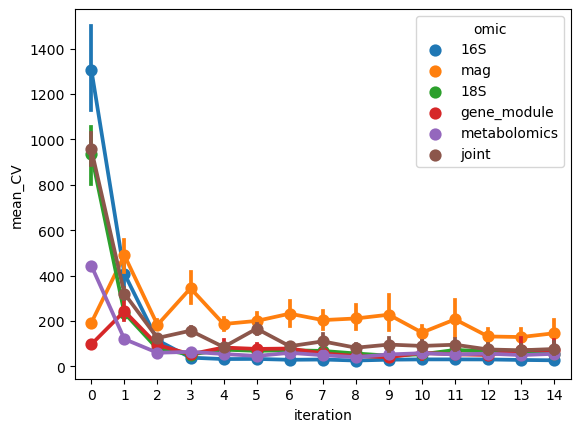

In [79]:
sns.pointplot(x='iteration', y='mean_CV', hue='omic', data=cv_save_all_df)
plt.show()

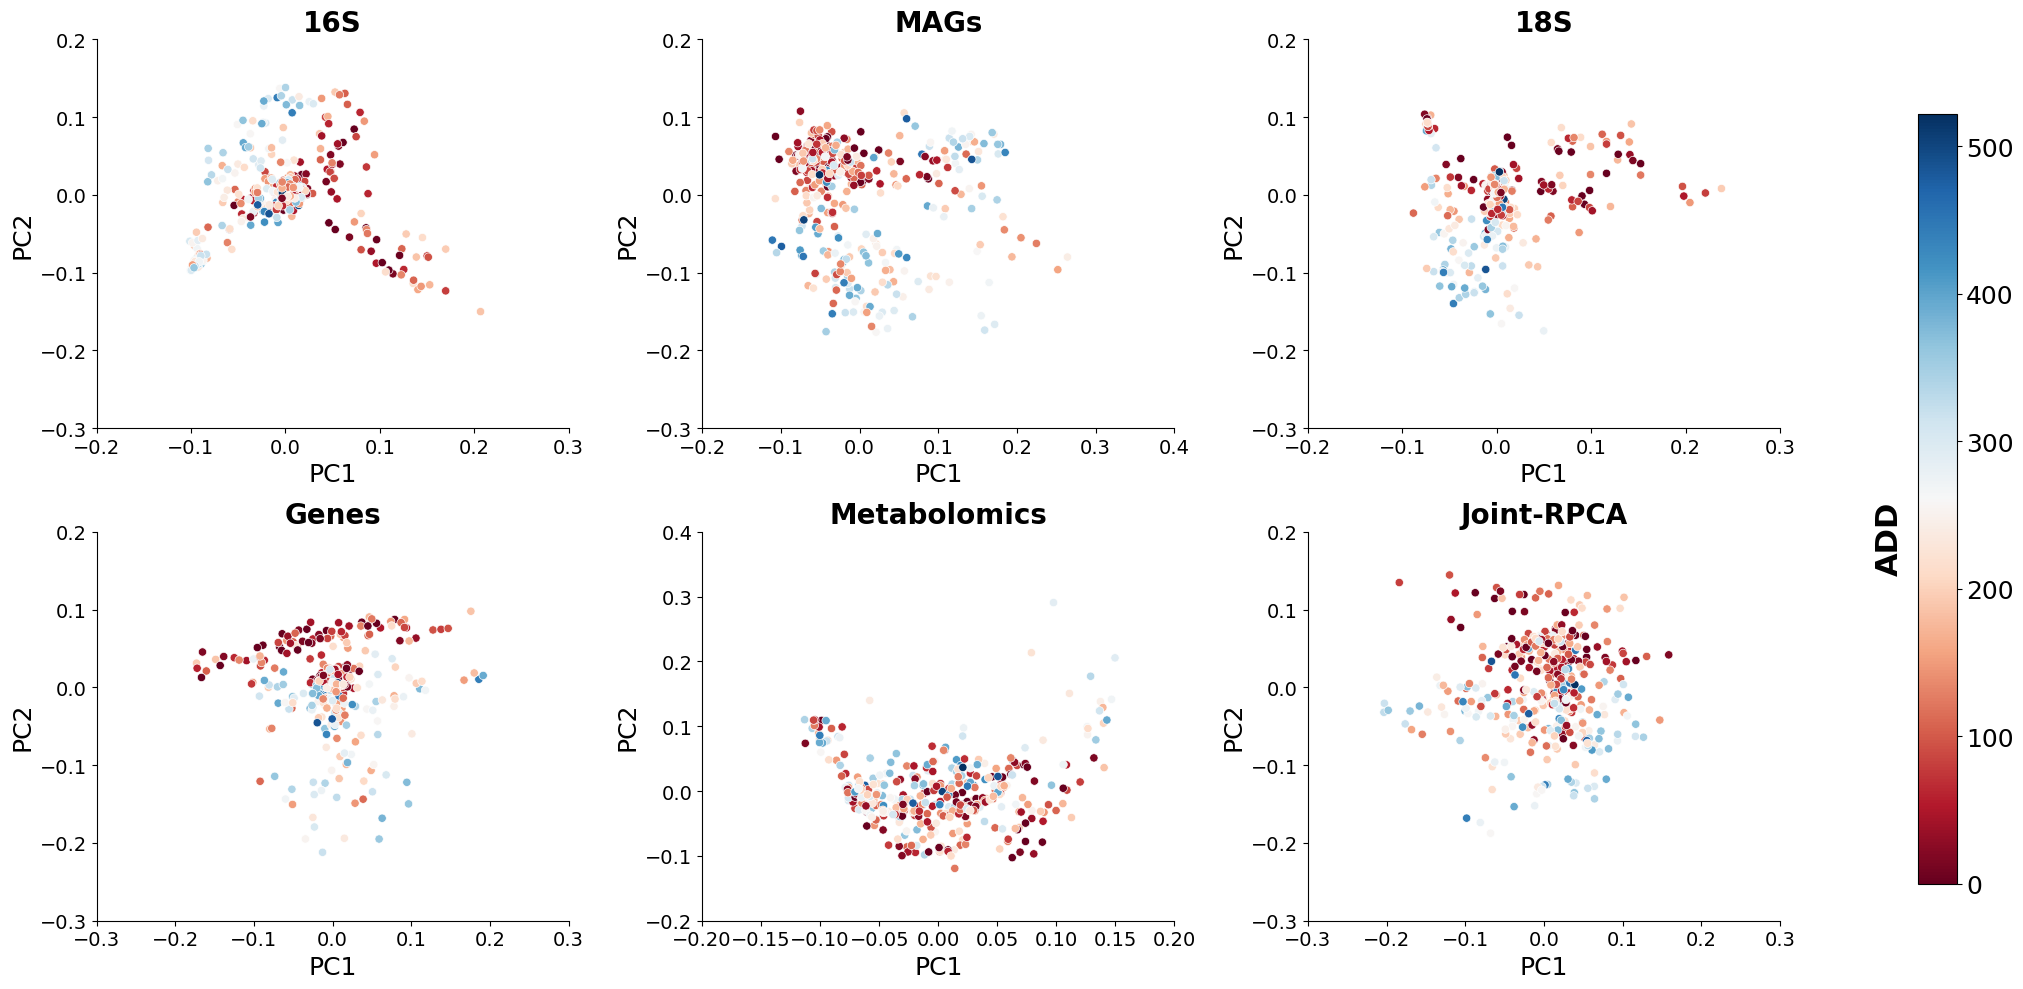

In [80]:
"""
Plot the ordinations of each metric/omic
"""

omics_ = ['16S', 'mag', '18S', 'gene_module', 'metabolomics','joint']
relabelfor_plot = {'16S':'16S', 
                   'mag':'MAGs', 
                   '18S':'18S', 
                   'gene_module':'Genes', 
                   'metabolomics':'Metabolomics',
                   'joint':'Joint-RPCA'}
fold_ = 'traintest_11'
vmin, vmax = metadata['add_0c'].min(), metadata['add_0c'].max()
pal_ = 'RdBu'

fig, axn = plt.subplots(2, 3, figsize=(18, 10))

for k_, ax in zip(omics_, axn.flatten()):


    tst_ = pd.concat([ord_save_all[(k_, fold_)].samples.copy(), metadata],axis=1)
    sns.scatterplot(x='PC1',y='PC2', hue='add_0c', data=tst_, ax=ax, palette=pal_, vmin=vmin, vmax=vmax)
    ax.set_title(relabelfor_plot[k_], fontsize=20, color='black', weight='bold')
    ax.set_xlabel('PC1', fontsize=18, color='black', weight='normal')
    ax.set_ylabel('PC2', fontsize=18, color='black', weight='normal')

    ax.legend_.remove()


    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['left'].set_bounds(np.round(tst_['PC2'].min(), 1)- .1, np.round(tst_['PC2'].max(), 1)+ .1)
    ax.set_ylim(np.round(tst_['PC2'].min(), 1)- .1, np.round(tst_['PC2'].max(), 1)+ .1)
    ax.spines['bottom'].set_bounds(np.round(tst_['PC1'].min(), 1)- .1, np.round(tst_['PC1'].max(), 1) + .1)
    ax.set_xlim(np.round(tst_['PC1'].min(), 1)- .1, np.round(tst_['PC1'].max(), 1) + .1)

    for tick in ax.get_yticklabels():
        tick.set_weight('normal')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_weight('normal')
        tick.set_color("black")
        tick.set_fontsize(14)
    fig.patch.set_facecolor('blue')
    fig.patch.set_alpha(0)
    ax.set_facecolor('white')
    ax.patch.set_alpha(0)

norm = plt.Normalize(metadata['add_0c'].min(), metadata['add_0c'].max())
sm = plt.cm.ScalarMappable(cmap=pal_, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
#plt.figure.(sm)
cbar = fig.colorbar(sm, ax=axn.flatten(), orientation="vertical", anchor=(3,3), label='ADD')
cbar.ax.tick_params(labelsize=18) 
cbar.set_label('ADD', labelpad=-100, y=0.45, fontsize=22, weight='bold')

plt.tight_layout()
plt.show()

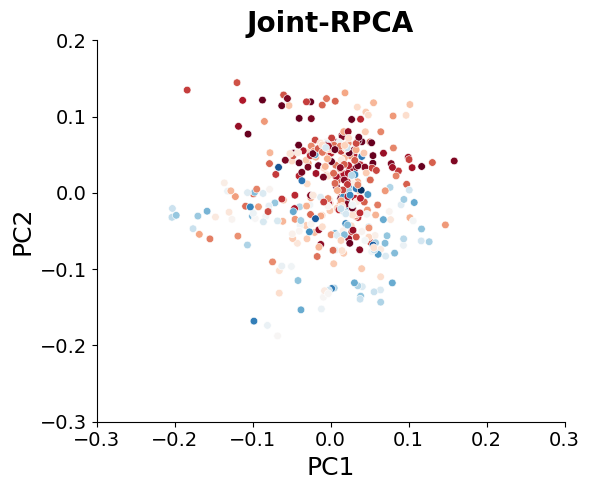

In [81]:
"""
Plot the ordinations of each metric/omic
"""

omics_ = ['16S', 'mag', '18S', 'gene_module', 'metabolomics','joint']
relabelfor_plot = {'16S':'16S', 
                   'mag':'MAGs', 
                   '18S':'18S', 
                   'gene_module':'Genes', 
                   'metabolomics':'Metabolomics',
                   'joint':'Joint-RPCA'}
fold_ = 'traintest_11'
vmin, vmax = metadata['add_0c'].min(), metadata['add_0c'].max()
pal_ = 'RdBu'

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

k_ = 'joint'
tst_ = pd.concat([ord_save_all[(k_, fold_)].samples.copy(), metadata],axis=1)
sns.scatterplot(x='PC1',y='PC2', hue='add_0c', data=tst_, ax=ax, palette=pal_, 
                vmin=vmin, vmax=vmax, s=30)
ax.set_title(relabelfor_plot[k_], fontsize=20, color='black', weight='bold')
ax.set_xlabel('PC1', fontsize=18, color='black', weight='normal')
ax.set_ylabel('PC2', fontsize=18, color='black', weight='normal')

ax.legend_.remove()


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['left'].set_bounds(np.round(tst_['PC2'].min(), 1)- .1, np.round(tst_['PC2'].max(), 1)+ .1)
ax.set_ylim(np.round(tst_['PC2'].min(), 1)- .1, np.round(tst_['PC2'].max(), 1)+ .1)
ax.spines['bottom'].set_bounds(np.round(tst_['PC1'].min(), 1)- .1, np.round(tst_['PC1'].max(), 1) + .1)
ax.set_xlim(np.round(tst_['PC1'].min(), 1)- .1, np.round(tst_['PC1'].max(), 1) + .1)

for tick in ax.get_yticklabels():
    tick.set_weight('normal')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_weight('normal')
    tick.set_color("black")
    tick.set_fontsize(14)
fig.patch.set_facecolor('blue')
fig.patch.set_alpha(0)
ax.set_facecolor('white')
ax.patch.set_alpha(0)

norm = plt.Normalize(metadata['add_0c'].min(), metadata['add_0c'].max())
sm = plt.cm.ScalarMappable(cmap=pal_, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
#plt.figure.(sm)
cbar = fig.colorbar(sm, ax=axn.flatten(), orientation="vertical", anchor=(3,3), label='ADD')
cbar.ax.tick_params(labelsize=18) 
cbar.set_label('ADD', labelpad=-100, y=0.45, fontsize=22, weight='bold')
plt.tight_layout()

plt.show()


In [82]:
# save all 
metadata.to_csv('../../data/case-studies/decomposer/machine-learning/splits_metadata.csv')
cv_save_all_df.to_csv('../../data/case-studies/decomposer/machine-learning/rpca_joint_rpca_cv_scores_all.csv')
# write the Ordination results (don't need distances - can get from ord if we need...)
for (k1, k2), ord_out_ in ord_save_all.items():
    ord_out_.write('../../data/case-studies/decomposer/machine-learning/ordinations/%s.%s.txt' % (k1, k2))
